## 위치 측정을 위한 라벨링 툴 만들기 (2) 툴 만들기

이제 OpenCV의 마우스 이벤트를 이용해서 라벨링 툴(labeling tool)을 만들어보겠습니다.

아래 코드는 필요한 패키지를 불러옵니다. 주로 **cv2** 를 이용합니다. 이번에는 기존 라벨을 읽지 않고 새로 위치를 정하기 때문에 **img_path** 만 불러오면 됩니다. **flg_button** 은 마우스 이벤트가 발생할 때 사용할 불리언(boolean) 타입 전역변수입니다.

### keypoint_using_mouse.py
---

``` python
import os
from os.path import join
from glob import glob
import cv2
import argparse
import numpy as np
import json
from pprint import pprint

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('img_path', type=str, nargs='?', default=None)

config = args.parse_args()

flg_button = False

```

사용할 함수를 만들겠습니다.

해당 함수에서는 먼저 **`img_path`** 가 유효한지 체크합니다. **`img_path`** 로 디렉토리가 입력될 경우 해당 디렉토리 내의 첫 번째 이미지를 **`img_path`** 에 입력하고 경로를 반환합니다.

이미지 간 이동할 **`move()`** 함수도 선언합니다.

``` python

def check_dir():
    if config.img_path is None \
        or len(config.img_path) == 0 \
        or config.img_path == '' \
        or os.path.isdir(config.img_path):
        root = os.path.realpath('./')
        if os.path.isdir(config.img_path):
            root = os.path.realpath(config.img_path)
        img_list = sorted(glob(join(root, '*.png')))
        img_list.extend(sorted(glob(join(root, '*.jpg'))))
        config.img_path = img_list[0]

    img_dir = os.path.dirname(os.path.realpath(config.img_path))

    return img_dir

def move(pos, idx, img_list):
    if pos == 1:
        idx += 1
        if idx == len(img_list):
            idx = 0
    elif pos == -1:
        idx -= 1
        if idx == -1:
            idx = len(img_list) - 1
    return idx

```

mouse callback 함수를 정의합니다. 전역변수인 **`gparam`** 에는 **`img`**와 **`point`** 정보를 저장합니다. 마우스 왼쪽 버튼이 눌러졌다 떨어질 때 **`gparam`** 의 **`point`** 에 **`x, y`** 를 리스트로 저장합니다.

``` python
# Mouse callback function
def select_point(event, x,y, flags, param):
    global flg_button, gparam
    img = gparam['img']

    if event == cv2.EVENT_LBUTTONDOWN:
        flg_button = True

    if event == cv2.EVENT_LBUTTONUP and flg_button == True:
        flg_button = False
        print (f'({x}, {y}), size:{img.shape}')
        gparam['point'] = [x,y]
        
```

**`main`** 함수인 **`blend_view()`** 를 구현합시다. 마찬가지로 코드를 복사해 **`keypoint_using_mouse.py`**에 붙여넣어 주세요.

#### blend_view 함수 
<details>

``` python

    def blend_view():
        global gparam
        gparam = {}
        cv2.namedWindow('show', 0)
        cv2.resizeWindow('show', 500, 500)

        img_dir = check_dir()

        fname, ext = os.path.splitext(config.img_path)
        img_list = [os.path.basename(x) for x in sorted(glob(join(img_dir,'*%s'%ext)))]

        dict_label = {}
        dict_label['img_dir'] = img_dir
        dict_label['labels'] = {}

        json_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/eye_annotation.json'
        json_file = open(json_path, 'w', encoding='utf-8')

        idx = img_list.index(os.path.basename(config.img_path))
        pfname = img_list[idx]
        orig = None
        local_point = [] # 저장할 point list
        while True:
            start = cv2.getTickCount()
            fname = img_list[idx]
                    # 파일의 변경이 없거나 이미지가 없을 때, point 를 초기화함
            if pfname != fname or orig is None:
                orig = cv2.imread(join(img_dir, fname), 1)
                gparam['point'] = []
                pfname = fname
                    # 저장할 point(local point) 와 새로 지정한 gparam['point'] 가 변경된 경우,
                    # local_point 를 업데이트
            if local_point != gparam['point']:
                orig = cv2.imread(join(img_dir, fname), 1)
                local_point = gparam['point']

            img_show = orig
            gparam['img'] = img_show
            # gparm의 mouse로 클릭한 (x,y) 좌표 기록
            cv2.setMouseCallback('show', select_point) # mouse event

            if len(local_point) == 2:
                img_show = cv2.circle(img_show, tuple(local_point),
                                      2, (0,255,0), -1)
                dict_label['labels'][fname] = local_point # label 로 저장

            time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

            if img_show.shape[0] > 300:
                cv2.putText(img_show, '%s'%fname, (5,10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (255,255,255))

            print (f'[INFO] ({idx+1}/{len(img_list)}) {fname}... time: {time:.3f}ms', end='\r')

            cv2.imshow('show', img_show)

            # 종료 ESC
            key = cv2.waitKey(1)
            if key == 27:
                return -1
            if key == ord('n'):
                idx = move(1, idx, img_list)
            elif key == ord('p'):
                idx = move(-1, idx, img_list)
            elif key == ord('v'):
                print ()
                pprint (dict_label)
                print ()
            elif key == ord('s'):
                json.dump(dict_label, json_file, indent=2)
                print (f'[INFO] < {json_path} > saved!')

    if __name__ == '__main__':
        blend_view()


    ```
    
</details>

**`main`** 함수인 **`blend_view()`** 는 이론 노드에서 만든 라벨링 툴의 구조와 비슷하게 구현했습니다.

달라진 점은,

- 마우스 이벤트를 사용하기 위해 무한루프를 사용해서 **`gparam`**을 입력 받을 수 있게 한 것


- 이미지 변경이 없다면 **gparam['point']** 를 초기화하지 않을 것


- 이미지 변경이 없더라도 callback 함수에서 **gparam** 변경이 일어나는 경우는 수정할 것

이 있습니다.

만든 프로그램을 실행시켜서 마우스로 점을 찍어 봅시다.

우선 위 이미지를 다운받아, **`eye.png`** 이름으로 현재 프로젝트 폴더의 하위 디렉토리인 **`data`** 에 저장한 후, 아래 코드를 터미널에서 실행합니다.

눈동자 지점을 클릭한 후 **`s`**를 눌러 저장하면 **`esc`**를 눌러 프로그램을 종료할 때 **`~/aiffel/coarse_to_fine/eye_annotation.json`** 에 레이블이 저장됩니다.

이제 레이블을 모아서 학습시킬 수 있습니다!

---

## 데이터를 모아보자

이제 라벨링할 초기 데이터를 수집해야 합니다. 직접 촬영한 데이터를 쓸 수도 있지만 들이는 노력에 비해 데이터가 많이 모이지 않습니다. 때문에 공개된 데이터를 적극적으로 활용할 필요가 있습니다.

우리가 모아야 할 라벨은 눈동자 위치이기 때문에 아래 순서로 데이터셋을 찾으면 좋습니다.

1. 눈이 crop 되어 있고 눈동자 위치를 라벨로 가지고 있는 데이터   
2. 얼굴 랜드마크(face landmark)를 가지고 있는 데이터   
3. 얼굴 이미지를 가지고 있는 데이터   

1번에 해당하는 데이터셋은 **BioID** 가 있습니다.

- [BioID Face Database | Dataset for Face Detection | facedb - BioID](https://www.bioid.com/facedb/)

BioID의 경우 우리가 해결해야 할 문제를 위한 데이터셋이지만 규모가 너무 작다는 단점이 있습니다. 충분한 양의 이미지를 수집하기 위해 다른 데이터셋도 조사해야 합니다.

얼굴 랜드마크가 제공되는 데이터를 생각해봅시다. 랜드마크가 제공되는 경우는 눈 부분의 사진을 쉽게 crop해서 사용할 수 있기 때문에 라벨을 쉽게 만들 수 있습니다.



### 랜드마크를 제공하는 데이터셋을 찾아보자
---
랜드마크를 제공하는 데이터셋을 찾아봅시다. 데이터를 어떻게 찾아가는지 함께 고민하는 것에 집중해주세요.

우리는 **`dlib`** 패키지의 얼굴 랜드마크를 사용해오고 있습니다. 그렇다면 **`dlib`** 패키지를 구현하기 위해 사용된 랜드마크는 어떤 데이터셋으로 학습되었을까? 를 생각해보면 간단히 데이터를 찾을 수 있습니다.

구글에 "dlib face landmark dataset"을 검색해봅시다. 검색 첫 페이지에서 아래 링크를 찾을 수 있습니다.

- http://dlib.net/face_landmark_detection.py.html

주석을 몇 줄 읽어보면 어떤 데이터셋을 사용해서 학습했는지 친절하게 안내되어 있습니다.



``` python
#   and was trained on the iBUG 300-W face landmark dataset (see
#   https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/):
```

**`iBUG 300-W`** 라는 데이터셋으로 학습했다고 합니다. 이 데이터셋을 이용하는 방법도 유용할 겁니다.

이 경우에는 운이 좋았습니다. 하지만 실무에서 대부분의 경우는 내가 풀고자 하는 문제의 관련 도메인 데이터셋이 없기 때문에 위에서 알아본 방법 중 3번 방법도 고려해야 합니다.

3번 방법을 연습해 보기 위해, 오늘은 LFW 데이터셋을 사용해 봅시다. 이 데이터셋은 **안면 인식(face recognition)**과 관련된 데이터셋입니다 (해당 사진이 누구의 얼굴인지 판단하는 데이터셋이죠). 얼굴이 포함된 이미지만 있고 얼굴의 랜드마크에 대한 정보는 없는 데이터셋입니다. 이 이미지에 dlib을 적용해서 얼굴 위치와 랜드마크 위치를 찾고 눈을 잘라낸 뒤 라벨링을 할 수 있습니다.

데이터는 아래 링크에서 다운로드 받을 수 있습니다.

- http://vis-www.cs.umass.edu/lfw/lfw.tgz


위와 같이 다운로드 후 압축을 풀면 아래와 같은 이미지를 볼 수 있습니다.

![LFW%20%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%20%EC%98%88%EC%8B%9C.png](./images/LFW%20%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%20%EC%98%88%EC%8B%9C.png)

**[LFW 데이터셋 예시]**

## Mean-shift를 이용한 눈동자 검출 방법 (1) 이론

![Mean-shift_%EB%88%88%EB%8F%99%EC%9E%90_%EA%B2%80%EC%B6%9C.png](./images/Mean-shift_%EB%88%88%EB%8F%99%EC%9E%90_%EA%B2%80%EC%B6%9C.png)

눈동자를 어떻게 검출할까요? 쉽게 떠오르는 방법은 **"눈동자는 주변 부분에 비해 어두운 색을 지니고 있다."**를 가정으로 반전된 1D 이미지에서 최댓값을 찾는 방법입니다.



![Mean-shift_%EB%B0%98%EC%A0%84%EB%90%9C_%EB%88%88%EB%8F%99%EC%9E%90.png](./images/Mean-shift_%EB%B0%98%EC%A0%84%EB%90%9C_%EB%88%88%EB%8F%99%EC%9E%90.png)
**[위 이미지의 하단 및 우측 1차원 벡터에서 최대값을 찾는 방법을 사용했습니다.]**

물론 이와 같은 가우시안 블러가 모든 상황을 해결할 수 있는 방법은 아닙니다. 아래 이미지와 같이 눈 근처에 머리카락이 나타나서 눈 가장자리에 검정색이 큰 비중으로 등장하는 경우는 눈동자보다 가장자리에 수렴할 확률이 높습니다. 특히 머리가 긴 분들에게 자주 나타날 수 있는 현상입니다.

![%EB%88%88%EB%8F%99%EC%9E%90_%EB%A8%B8%EB%A6%AC%EC%B9%B4%EB%9D%BD.png](./images/%EB%88%88%EB%8F%99%EC%9E%90_%EB%A8%B8%EB%A6%AC%EC%B9%B4%EB%9D%BD.png)

2차원 블러 특성 이미지(feature image)에서는 눈동자가 2차원 정규분포로 나타나는 영역이 있는 것으로 보입니다. 하지만 1차원 누적 그래프를 보면 x축으로 2개의 봉우리를 가지는 것을 관찰할 수 있습니다. 최댓값을 찾는 알고리즘을 왼쪽부터 시작했다면 가장 왼쪽에서 만나는 255에 수렴할 것입니다.

따라서 우리는 **1D 누적 그래프**와 **2D 특성 이미지**를 모두 사용합니다. 2D에서는 어떻게 최고점을 찾아갈 수 있을까요?



![2D_%EC%B5%9C%EA%B3%A0%EC%A0%90_%EC%B0%BE%EA%B8%B0.png](./images/2D_%EC%B5%9C%EA%B3%A0%EC%A0%90_%EC%B0%BE%EA%B8%B0.png)

1. **이미지 중심점을 초기값으로 설정하겠습니다.**   
눈의 중심에 눈동자가 있을 확률이 높기 때문에 초기값으로 정하기에 아주 좋습니다.)   


2. **중심점을 기준으로 작은 box를 설정합니다.**   
box의 크기는 문제에 따라 적절한 값을 설정해야 합니다.   
그림에서 회색박스를 생각하시면 됩니다.  


3. **box 내부의 pixel 값을 이용해서 '무게중심'을 찾습니다.**   
이 때 무게중심은 pixel intensity를 weight 로 사용할 수 있습니다. [ *색깔이 더 진한 지점* ]   


4. **찾은 무게중심을 새로운 box의 중심으로 설정합니다.**    
이 단계에서 박스가 이동하게 됩니다. 이제 회색박스에서 초록색박스로 관심영역이 이동했습니다.   


5. **다시 초록색 박스를 기준으로 2-4를 반복합니다.**    


6. **중심점이 수렴할 때 까지 2~5를 반복하면 수렴한 점의 위치로 눈동자를 찾을 수 있습니다.**    

머신러닝에 이미 비슷한 알고리즘이 존재합니다. 현재 위치와 탐색반경을 가질 때 평균의 위치를 이용해서 반복적으로 움직이는 알고리즘인 **Mean Shift** 라는 알고리즘입니다

![mean_shift_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.png](./images/mean_shift_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98.png)

mean shift는 탐색반경 내 데이터 포인트의 평균을 구하고 평균 위치로 이동을 반복해 가면서 데이터 분포의 중심으로 이동합니다. 더 자세한 설명은 아래 링크를 참고해주세요.

- [영상추적#1 - Mean Shift 추적](https://darkpgmr.tistory.com/64)

---

## Mean-shift를 이용한 눈동자 검출 방법 (2) 실습
눈동자를 검출하는 mean shift 기법을 코드로 구현해 봅시다. 오늘의 시작포인트는 바로 지난 노드에서 구현해 보았던 눈동자 찾기 실습코드입니다.

해당 코드를 하나의 파일로 정리하여 **`eye_center_basic.py`**에 저장하였습니다. 이 코드를 이후 실습의 베이스라인으로 사용하겠습니다.


<details markdown="1">
<summary><b> ▶ eye_center_basic.py 코드 상세</b></summary>

<!--summary 아래 빈칸 공백 두고 내용을 적는공간-->
``` python
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib
import argparse

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('show_substep', type=bool, nargs='?', default=False)

config = args.parse_args()



img = cv2.imread('./images/image.png')
print (img.shape)

if config.show_substep:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

img_bgr = img.copy()

detector_hog = dlib.get_frontal_face_detector() # detector 선언
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_rgb, point, 2, (255, 255, 0), -1) # yellow

if config.show_substep:
    plt.imshow(img_rgb)
    plt.show()


def eye_crop(bgr_img, landmark):
    # dlib eye landmark: 36~41 (6), 42~47 (6)
    np_left_eye_points = np.array(landmark[36:42])
    np_right_eye_points = np.array(landmark[42:48])

    np_left_tl = np_left_eye_points.min(axis=0)
    np_left_br = np_left_eye_points.max(axis=0)
    np_right_tl = np_right_eye_points.min(axis=0)
    np_right_br = np_right_eye_points.max(axis=0)

    list_left_tl = np_left_tl.tolist()
    list_left_br = np_left_br.tolist()
    list_right_tl = np_right_tl.tolist()
    list_right_br = np_right_br.tolist()

    left_eye_size = np_left_br - np_left_tl
    right_eye_size = np_right_br - np_right_tl

    ### if eye size is small
    if left_eye_size[1] < 5:
        margin = 1
    else:
        margin = 6

    img_left_eye = bgr_img[np_left_tl[1]-margin:np_left_br[1]+margin, np_left_tl[0]-margin//2:np_left_br[0]+margin//2]
    img_right_eye = bgr_img[np_right_tl[1]-margin:np_right_br[1]+margin, np_right_tl[0]-margin//2:np_right_br[0]+margin//2]

    return [img_left_eye, img_right_eye]

# 눈 이미지 crop
img_left_eye, img_right_eye = eye_crop(img_bgr, list_landmarks[0])

print (img_left_eye.shape) # (26, 47, 3)

if config.show_substep:
    plt.imshow(cv2.cvtColor(img_right_eye, cv2.COLOR_BGR2RGB))
    plt.show()


# 눈 이미지에서 중심을 찾는 함수
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1

    return [center_x, center_y]

# 눈동자 검출 wrapper 함수
def detectPupil(bgr_img, landmark):
    if landmark is None:
        return

    img_eyes = []
    img_eyes = eye_crop(bgr_img, landmark)

    gray_left_eye = cv2.cvtColor(img_eyes[0], cv2.COLOR_BGR2GRAY)
    gray_right_eye = cv2.cvtColor(img_eyes[1], cv2.COLOR_BGR2GRAY)

    if gray_left_eye is None or gray_right_eye is None:
        return 

    left_center_x, left_center_y = findCenterPoint(gray_left_eye,'left')
    right_center_x, right_center_y = findCenterPoint(gray_right_eye,'right')

    return [left_center_x, left_center_y, right_center_x, right_center_y, gray_left_eye.shape, gray_right_eye.shape]

# 눈동자 중심 좌표 출력
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

# 이미지 출력
show = img_right_eye.copy()

show = cv2.circle(show, (right_center_x, right_center_y), 2, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()
```
</details>

이 코드의 동작은 아래와 같이 확인해 볼 수 있습니다. **`show_substep argument`**의 옵션을 True로 주게 되면 매 스텝의 작동을 차례차례 확인해볼 수 있습니다. 옵션을 False로 주거나 생략(기본옵션)하면 최종 결과만 확인하게 됩니다.

이제 mean shift 알고리즘을 적용해 봅시다. **`eye_center_basic.py`** 파일을 복사하여 **`eye_center_meanshift.py`**를 생성합니다.


**`eye_center_meanshift.py`** 파일을 편집기로 열어 기존 함수 중 **`findCenterPoint`**를 다음과 같이 수정합니다.


<details markdown="1">
<summary><b> ▶ findCenterPoint 함수</b></summary>

``` python  
def findCenterPoint(gray_eye, str_direction='left'):
    if gray_eye is None:
        return [0, 0]
    filtered_eye = cv2.bilateralFilter(gray_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)
    filtered_eye = cv2.bilateralFilter(filtered_eye, 7, 75, 75)

    # 2D images -> 1D signals
    row_sum = 255 - np.sum(filtered_eye, axis=0)//gray_eye.shape[0]
    col_sum = 255 - np.sum(filtered_eye, axis=1)//gray_eye.shape[1]

    # normalization & stabilization
    def vector_normalization(vector):
        vector = vector.astype(np.float32)
        vector = (vector-vector.min())/(vector.max()-vector.min()+1e-6)*255
        vector = vector.astype(np.uint8)
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))
        vector = cv2.blur(vector, (5,1)).reshape((vector.shape[0],))            
        return vector
    row_sum = vector_normalization(row_sum)
    col_sum = vector_normalization(col_sum)

    def findOptimalCenter(gray_eye, vector, str_axis='x'):
        axis = 1 if str_axis == 'x' else 0
        center_from_start = np.argmax(vector)
        center_from_end = gray_eye.shape[axis]-1 - np.argmax(np.flip(vector,axis=0))
        return (center_from_end + center_from_start) // 2

    # x 축 center 를 찾는 알고리즘을 mean shift 로 대체합니다.
    # center_x = findOptimalCenter(gray_eye, row_sum, 'x')
    center_y = findOptimalCenter(gray_eye, col_sum, 'y')

    # 수정된 부분
    inv_eye = (255 - filtered_eye).astype(np.float32)
    inv_eye = (255*(inv_eye - inv_eye.min())/(inv_eye.max()-inv_eye.min())).astype(np.uint8)

    resized_inv_eye = cv2.resize(inv_eye, (inv_eye.shape[1]//3, inv_eye.shape[0]//3))
    init_point = np.unravel_index(np.argmax(resized_inv_eye),resized_inv_eye.shape)

    x_candidate = init_point[1]*3 + 1
    for idx in range(10):
        temp_sum = row_sum[x_candidate-2:x_candidate+3].sum()
        if temp_sum == 0:
            break
        normalized_row_sum_part = row_sum[x_candidate-2:x_candidate+3].astype(np.float32)//temp_sum
        moving_factor = normalized_row_sum_part[3:5].sum() - normalized_row_sum_part[0:2].sum()
        if moving_factor > 0.0:
            x_candidate += 1
        elif moving_factor < 0.0:
            x_candidate -= 1

    center_x = x_candidate

    if center_x >= gray_eye.shape[1]-2 or center_x <= 2:
        center_x = -1
    elif center_y >= gray_eye.shape[0]-1 or center_y <= 1:
        center_y = -1

    return [center_x, center_y]

```
</details>

먼저, 눈 이미지를 low pass filter를 이용해서 smoothing 합니다. 저는 bilateral filter를 이용했습니다.

다음으로 1차원 값으로 누적시킨 후 **`y`** 축 기준으로 최대값을 찾아서 **`y`**축의 중심점 좌표를 먼저 얻어냅니다. (y 축은 x 축에 비해 상대적으로 변화가 적기 때문에 간단하게 구현합니다.)

**`x`**축은 1차원 최댓값 지점을 기준으로 mean shift를 수행합니다. 양 끝단에 수렴하는 예외를 처리한 후 결과를 출력합니다.



``` python

# 눈동자 중심 좌표 출력
left_center_x, left_center_y, right_center_x, right_center_y, le_shape, re_shape = detectPupil(img_bgr, list_landmarks[0])
print ((left_center_x, left_center_y), (right_center_x, right_center_y), le_shape, re_shape)

# 이미지 출력
show = img_right_eye.copy()
show = cv2.circle(show, (right_center_x, right_center_y), 2, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

```

결과를 뽑아보겠습니다.

```
$ cd ~/aiffel/coarse_to_fine && python eye_center_meanshift.py
```

![eye_center_meanshift%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EB%88%88%EB%8F%99%EC%9E%90%20%EA%B2%80%EC%B6%9C.png](./images/eye_center_meanshift%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EB%88%88%EB%8F%99%EC%9E%90%20%EA%B2%80%EC%B6%9C.png)

여전히 눈동자 중심은 아니어서 조금 아쉽습니다. 기존 머신러닝 기반 알고리즘으로는 성능을 큰 폭으로 향상시키기 어렵습니다. 하지만 예외 상황에 대해 더 강건한 모델을 만들 수 있는 장점이 있습니다. 일반화에 한 걸음 더 가까워지고 있습니다.

---

## 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인
더 나은 성능을 위해 딥러닝 모델을 만들어 보겠습니다. 지난 이론 시간에 배웠던 딥러닝 모델링 기법을 적용해 실제로 학습을 수행해보겠습니다.

이번 단계에서는 대량의 눈동자 위치 라벨이 필요합니다. 앞에서 만든 coarse dataset 또는 직접 어노테이션 한 라벨이 10,000개 이상 있어야 성능을 확인할 수 있습니다.

이전 스텝에서 다룬 눈동자 검출 방법을 LFW 데이터셋에 적용하여 필요한 만큼의 데이터셋을 생성해 봅시다. 데이터셋을 생성하는 코드 **`prepare_eye_dataset.py`**를 실행하면 아래 사용할 데이터셋이 LFW 데이터셋으로부터 가공 생성됩니다.   
생성된 데이터셋은 **`~/lfw/data/train, ~/lfw/data/valid`** 아래에서 확인할 수 있습니다.

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

TensorFlow Hub에서 제공하는 **pretrained image feature embedding**을 가지고 fine tuning을 해보겠습니다.

가지고 있는 데이터를 케라스 **`ImageDataGenerator`** 형식으로 읽습니다. 저는 라벨을 **`image`** 형태로 저장해 두었습니다.

In [2]:
import glob
import os

home_dir = os.getenv('HOME')+'/aiffel/coarse_to_fine'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23712 23712
Found 23712 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


train 데이터셋이 23,712쌍, val 데이터셋이 2,638쌍 생성될 것입니다.

>경우에 따라서는 train 데이터셋의 갯수가 23,712쌍과 다소 다르게 만들어질 수 있습니다. batch_size 32의 배수인 23,712쌍과 같아지도록 이미지 데이터의 갯수를 맞춰주도록 합시다. 32의 배수 조건만 만족하면 됩니다.

아래 코드에서는 **`image_generator`**, **`label generator를`** 학습할 수 있는 입출력 형식으로 편집합니다. 텐서플로우의 제너레이터(generator) 형식을 사용하고 있기 때문에 출력 형식도 맞추어 주겠습니다.

- 참고: [제너레이터](https://tensorflow.blog/%ED%9A%8C%EC%98%A4%EB%A6%AC%EB%B0%94%EB%9E%8C%EC%9D%84-%ED%83%84-%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EC%A0%9C%EB%84%88%EB%A0%88%EC%9D%B4%ED%84%B0/)

학습 라벨을 만들 때 3개의 점을 **`label`** 이미지에 표시했습니다. 눈의 왼쪽 끝점을 **`1`**의 값으로, 오른쪽 끝점은 **`2`**의 값으로, 가장 중요한 눈 중심(눈동자)는 **`3`**으로 인코딩 했습니다. **`np.where()`** 함수로 이미지에서 좌표로 복원합니다.

In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)  # eye middle [눈동자]

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

**Q10. 좌표로 복원할 때 eye_ls[1].mean() 으로 평균값을 구했습니다. 왜 그랬을까요? 어떤 장점을 활용하려고 한 걸까요?**
<br>

**A.**      
눈 크기가 이미지마다, 사람마다 다르기 때문에 반드시 resize를 해야 합니다. 이 때 라벨을 이미지에 하나의 점으로 표현하면 resize 과정에서 소실될 수 있습니다. 이런 단점을 극복하기 위해 라벨 이미지를 만들 때 gaussian smoothing을 적용해서 변화에 유연하게 대응 할 수 있도록 했습니다. 이 방법을 취하면 이후 augmentation을 구현할 때도 추가적인 노력없이 바로 라벨을 사용할 수 있습니다.

만들어진 제너레이터로 데이터 포인트를 뽑아 관찰해 봅시다.

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.23333333 0.40845093]
(80, 120, 3) [0.         0.         1.         1.         0.04947917 0.40693933]


/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


120x80의 정해진 크기로 이미지가 잘 출력되고 라벨 또한 0~1 값으로 정규화(normalize) 되어 있는 것을 확인할 수 있습니다.

---

## 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계

데이터가 준비되었으니 이제 네트워크를 디자인합니다. 우리는 데이터가 없는 상황이기 때문에 미리 학습된 모델을 적극적으로 활용해야 합니다. TensorFlow Hub에서 ResNet의 특성추출기 부분을 백본(backbone)으로 사용하겠습니다.

**`tf.keras.Sequential()`**을 이용해서 백본 네트워크와 fully connected layer를 쌓아서 아주 쉽게 모델을 완성할 수 있습니다. 데이터 제너레이터를 만들 때 출력을 6개((x, y) 좌표 2개 * 점 3개) 로 했기 때문에 **`num_classes`** 는 6으로 설정합니다.

#### 예시 코드 

<details>

``` python
    
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

```
    
</details>

In [5]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='sigmoid'),
])

(32, 2048)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 **`loss`**와 **`metric`**을 각각 **mse** 와 **mae** 로 설정했습니다. **mae** 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습할 수 있습니다.

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

학습률(learning rate)을 조절하는 함수도 제작해 줍니다. 저는 지수적으로 감소하게 만들었습니다.

In [8]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

학습을 진행합니다.

In [9]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23712 32 741
Epoch 1/10


/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


741/741 [==============================] - 24s 32ms/step - loss: 0.0195 - mae: 0.0691
Epoch 2/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0142 - mae: 0.0560
Epoch 3/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0136 - mae: 0.0544
Epoch 4/10
741/741 [==============================] - 17s 22ms/step - loss: 0.0132 - mae: 0.0532
Epoch 5/10
741/741 [==============================] - 17s 22ms/step - loss: 0.0131 - mae: 0.0529
Epoch 6/10
741/741 [==============================] - 17s 22ms/step - loss: 0.0130 - mae: 0.0525
Epoch 7/10
741/741 [==============================] - 17s 22ms/step - loss: 0.0128 - mae: 0.0522
Epoch 8/10
741/741 [==============================] - 17s 22ms/step - loss: 0.0128 - mae: 0.0521
Epoch 9/10
741/741 [==============================] - 17s 23ms/step - loss: 0.0128 - mae: 0.0520
Epoch 10/10
741/741 [==============================] - 17s 22ms/step - loss: 0.0128 - mae: 0.0520


---

## 키포인트 검출 딥러닝 모델 만들기 (3) 평가

검증(validation)용 데이터는 섞어줄(shuffle) 필요가 없기 때문에 **`shuffle=False`** 옵션을 추가했습니다.

In [10]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/aiffel/coarse_to_fine'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2632 images belonging to 1 classes.
Found 2632 images belonging to 1 classes.


제너레이터를 만들고 **evaluate_generator()** 로 평가를 수행합니다.

In [11]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.01301558967679739 0.05218283832073212


저는 평균 에러가 0.026 정도 나왔습니다. 우리가 찍은 점들은 120 픽셀을 기준으로 **`120\*0.026 = 3.12`** 픽셀 정도 에러가 나는 것을 확인할 수 있습니다.

실제로 이미지에 출력해보겠습니다.

In [12]:
val_data_root

'/home/ssac27/aiffel/coarse_to_fine/data/val/input'

In [27]:
home_dir

'/home/ssac27/aiffel/coarse_to_fine'

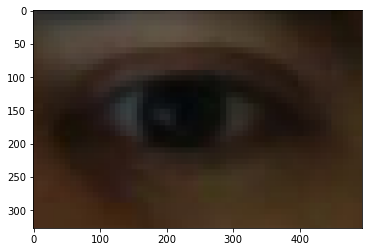

In [35]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(home_dir+'/data/eye.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

입력을 위해 이미지를 120x80 으로 resize 한 후, 배치(batch)를 나타낼 수 있는 4차원 텐서로 변경합니다. 우선 이미지 1장에 대해서 출력을 하려 하니 지금은 배치 크기(batch size)를 1로 만들면 되겠죠?



In [36]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[2.3486724e-03 4.5909462e-03]
  [1.1997748e+02 7.9990662e+01]
  [5.2574650e+01 2.4858391e+01]]]


출력결과를 뽑아보면 아래와 같이 나옵니다. 1행부터 좌측, 우측, 중앙 좌표를 나타냅니다.

결과를 이미지에 출력해 볼까요? **`pt`** 값은 120x80 으로 뽑았는데 우리가 사용하는 데이터 크기는 60x40입니다. 따라서 **`pt`** 에 **`0.5`** 를 곱해서 그림에 출력합니다.

>(주의) **pt**값을 뽑을때의 이미지 크기 기준(120X80)은 고정이지만, 사용하는 데이터의 크기는 매번 달라질 것입니다. 보정치 설정에 유의해 주세요.

[0. 0.]
[120.  80.]
[53. 25.]


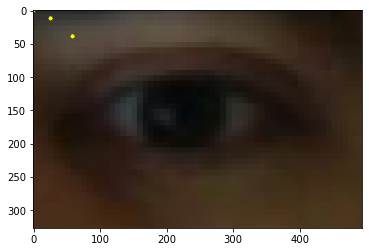

In [37]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

눈의 왼쪽은 정말 잘 찾은 것 같아요. 반면 눈 중심과 오른쪽 위치는 5픽셀 정도의 오차를 보이는 것 같습니다. 더 정확한 성능(적은 에러)를 원한다면 데이터를 추가로 넣어야 할 것 같습니다.